# Table of Contents
* [EDA on Tight End Performance over the last 10 years](#intro)
* [Importing Libraries and Data](#import)
* [Exploratory Data Analysis](#eda)

## EDA on Tight End Performance over the last 10 years <a class="anchor" id="intro"></a>
Reports are coming out about how the I. Likely usage will go up and I am going to research the likelihood that two Tight Ends from one team can be fantasy relevent. 

## Importing Libraries and Data<a id="import"></a>

In [5]:
import nfl_data_py as nfl
import numpy as np
np.float_ = np.float64
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
#Loading initial data for EDA for the years of 2014 to 2023. Just using regular season since this is the main fantasy football time. 
years = list(range(2014,2024))
data = nfl.import_seasonal_data(years, 'REG')

In [6]:
#Loading the id dataset to be able to grab the position column of the players.
ids = nfl.import_ids()
data_name = pd.merge(data,ids,how='left',left_on='player_id',right_on='gsis_id')
#Removing unneccesary columns from initial dataset
data_name.drop(['mfl_id',
       'sportradar_id', 'fantasypros_id', 'gsis_id', 'pff_id', 'sleeper_id',
       'nfl_id', 'espn_id', 'yahoo_id', 'fleaflicker_id', 'cbs_id',
       'rotowire_id', 'rotoworld_id', 'ktc_id', 'pfr_id', 'cfbref_id',
       'stats_id', 'stats_global_id', 'fantasy_data_id', 'swish_id',
       'merge_name', 'birthdate', 'age', 'draft_year',
       'draft_round', 'draft_pick', 'draft_ovr', 'twitter_username', 'height',
       'weight', 'college', 'db_season'],axis=1,inplace=True)
data_name.drop(['season_type'],axis=1,inplace=True)
#Filtering out all of the TEs
te_data = data_name[data_name['position']=='TE']

In [7]:
#Cleaning out columns further for the TE dataset
columns = ['completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions','receiving_fumbles', 'receiving_fumbles_lost','wopr_x',
       'special_teams_tds','dom', 'w8dom', 'yptmpa', 'fantasy_points']
te_data.drop(columns,axis=1,inplace=True)

Column	is short for\
tgt_sh	target share\
ay_sh	air yards share\
yac_sh	yards after catch share\
wopr	weighted opportunity rating\
ry_sh	receiving yards share\
rtd_sh	receiving TDs share\
rfd_sh	receiving 1st Downs share\
rtdfd_sh	receiving TDs + 1st Downs share\
dom	dominator rating\
w8dom	dominator rating, but weighted in favor of receiving yards over TDs\
yptmpa	receiving yards per team pass attempt\
ppr_sh	PPR fantasy points share\

In [8]:
te_data.columns

Index(['player_id', 'season', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'racr', 'target_share', 'air_yards_share', 'fantasy_points_ppr',
       'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh',
       'rfd_sh', 'rtdfd_sh', 'ppr_sh', 'name', 'position', 'team'],
      dtype='object')

In [9]:
te_data.to_csv('./../data/raw/te_data_2014_2024.csv')

## Exploratory Data Analysis<a id="eda"></a>

In [10]:
#Adding a seasonal rank column for each TE
df = te_data
df["rank"] = df.groupby("season")["fantasy_points_ppr"].rank(method="dense", ascending=False)
#Reason I am doing 13 is because after realizing that some of the TE were actually WRs I concluded that I needed to add in a replacement TE for the WR for consistency.
top_12_df = df[df['rank'] <= 13] 

In [11]:
#Looking at the unique team for each year I can tell we are missing the team data we need. 
top_12_df.groupby('season')['team'].nunique()

season
2014     4
2015     3
2016     4
2017     5
2018     8
2019     9
2020    11
2021    14
2022    12
2023    13
Name: team, dtype: int64

In [12]:
#Ran into an issue with the dataset where once a player retired they are put as FA and since we are going ten years in the past alot of the players we are looking at are retired 
# so I am replacing FA with their team for that specific year.

rosters=nfl.import_seasonal_rosters(years)
for index, row in top_12_df.iterrows():
    if row['team'] == 'FA':
        top_12_df.at[index,'team'] = rosters.loc[(rosters['player_id'] == row.player_id) & (rosters['season'] == row.season)]['team'].values[0]

In [13]:
top_12_df.groupby('season')['team'].nunique()
#With multiple seasons having less than 12 unique teams this shows me how often 2 tight ends from one team can be fantasy relevent. Fantasy relevent means a top 12 Tight End for the year.

season
2014    12
2015    12
2016    11
2017    13
2018    13
2019    12
2020    13
2021    14
2022    12
2023    13
Name: team, dtype: int64

In [14]:
#2021 is an outlier since there were two players with same fantasy_points_ppr values.
top_12_df.groupby('season').get_group(2021).sort_values(by='rank')['fantasy_points_ppr']

4619    301.1
1911    262.8
4431    208.8
3701    198.0
1642    180.7
5760    176.6
692     171.2
4388    165.0
4699    165.0
3578    164.3
5185    163.7
5135    159.0
5713    151.7
3607    147.0
Name: fantasy_points_ppr, dtype: float64

In [15]:
#On average for the last 10 years, TE #12 scores 143.73 points
num_12_df = df[df['rank'] == 12]
num_12_df.fantasy_points_ppr.describe()

count     10.00000
mean     143.73000
std        9.23015
min      130.60000
25%      137.22500
50%      141.55000
75%      151.02500
max      160.10000
Name: fantasy_points_ppr, dtype: float64

After researching the seasons with fewer than 12 unique team names in the column, two of the examples will ne removed because they include WRs who converted to TE after that particular season. 

In [16]:
#Dropping the WR rows and replacing them with TE rows
top_12_df.drop([2442,2443,2888],inplace=True)

In [17]:
#Rerank after removing rows
top_12_df["rank"] = top_12_df.groupby("season")["fantasy_points_ppr"].rank(method="dense", ascending=False)

In [18]:
top_12_df = top_12_df[top_12_df['rank'] <=12]
top_12_df.groupby('season')['team'].nunique()

season
2014    12
2015    11
2016    11
2017    12
2018    12
2019    11
2020    12
2021    13
2022    11
2023    12
Name: team, dtype: int64

In [19]:
#Filtering down the top 12 df to the years where there were two top 12 TEs from the same team
processed = top_12_df.loc[(top_12_df.season == 2015) | (top_12_df.season == 2016) | (top_12_df.season == 2019) | (top_12_df.season == 2020)| (top_12_df.season == 2022)]

In [20]:
# Step 1: Group by 'group' column and count occurrences of each 'value'
value_counts = processed.groupby('season')['team'].value_counts().reset_index(name='count')

# Step 2: Filter to keep only the rows where 'count' is exactly 2
values_with_exactly_two = value_counts[value_counts['count'] == 2]

# Step 3: Merge the result with the original DataFrame to filter the rows
filtered_df = processed.merge(values_with_exactly_two[['season', 'team']], on=['season', 'team'])

# Display the filtered DataFrame
print("\nFiltered DataFrame:")
print(filtered_df.sort_values(by='season'))


Filtered DataFrame:
    player_id  season  receptions  targets  receiving_yards  receiving_tds  \
0  00-0030061    2015          75      112            853.0              2   
2  00-0030472    2015          87      114            952.0             11   
1  00-0030061    2016          78      106            816.0              4   
3  00-0030472    2016          66       89            686.0              6   
4  00-0032392    2019          75       97            787.0              6   
5  00-0033090    2019          55       76            652.0              5   
6  00-0033757    2020          52       59            586.0             11   
8  00-0035229    2020          67      101            723.0              6   
7  00-0033895    2022          58       87            555.0              4   
9  00-0036290    2022          50       69            544.0              7   

   receiving_air_yards  receiving_yards_after_catch  receiving_first_downs  \
0                948.0                    

In [21]:
filtered_df['fppg'] = filtered_df['fantasy_points_ppr']/filtered_df['games']

In [22]:
filtered_df.to_csv('./../data/processed/processed.csv', index=False)
top_12_df.to_csv('./../data/processed/top_12_2014_2024.csv',index=False)

#Findings\
The data shows that in the last ten years there has been 5 times where 2 tight ends have finished in the top 12 from the same team. The likelihood is higher than expected. 

#Next Steps\
Analyze the top 12 te for patterns on trends and on how the cutoff for a top 12 te. Then research I. Likely on how big of a jump from last year production that the player will have to make. 

Also clean the colums of the datasets. Do not need the rushing columns and most of the advanced stats.

,season,receptions,targets,receiving_yards,receiving_tds,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,...,ay_sh,yac_sh,wopr_y,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,ppr_sh,rank,fppg
season,1.000000,-0.789030,-0.696096,-0.849254,0.073394,-0.786335,-0.244914,-0.807216,-0.441147,0.506979,...,-0.794293,-0.140601,-0.815163,-0.651397,-0.065378,-0.596893,-0.496821,-0.686162,0.274992,-0.716273
receptions,-0.789030,1.000000,0.925921,0.960498,-0.045134,0.673026,0.669402,0.892692,0.323570,-0.176975,...,0.554744,0.454902,0.733729,0.652569,0.093273,0.494438,0.410192,0.715328,-0.405749,0.744210
targets,-0.696096,0.925921,1.000000,0.877397,-0.327219,0.755524,0.637022,0.745386,-0.022677,-0.034871,...,0.595127,0.369201,0.719125,0.541273,-0.122086,0.371233,0.255589,0.515069,-0.154025,0.491981
receiving_yards,-0.849254,0.960498,0.877397,1.000000,-0.000788,0.773092,0.569049,0.914886,0.385144,-0.228437,...,0.690222,0.379296,0.819913,0.712119,0.082395,0.579190,0.485501,0.743966,-0.480421,0.762820
receiving_tds,0.073394,-0.045134,-0.327219,-0.000788,1.000000,-0.478644,0.293422,0.258858,0.801216,-0.282109,...,-0.396276,0.333773,-0.139751,0.037318,0.639993,0.235339,0.364023,0.277640,-0.723269,0.399558
receiving_air_yards,-0.786335,0.673026,0.755524,0.773092,-0.478644,1.000000,0.053376,0.600502,-0.021461,-0.103915,...,0.933927,-0.073744,0.806620,0.583669,-0.243179,0.431806,0.284085,0.469142,-0.070035,0.388384
receiving_yards_after_catch,-0.244914,0.669402,0.637022,0.569049,0.293422,0.053376,1.000000,0.570873,0.205626,-0.083162,...,-0.038902,0.748868,0.332448,0.318988,0.243803,0.300452,0.302259,0.397029,-0.362868,0.422753
receiving_first_downs,-0.807216,0.892692,0.745386,0.914886,0.258858,0.600502,0.570873,1.000000,0.613337,-0.191459,...,0.516831,0.401497,0.737236,0.607888,0.303303,0.599185,0.548823,0.811669,-0.589597,0.910772
receiving_epa,-0.441147,0.323570,-0.022677,0.385144,0.801216,-0.021461,0.205626,0.613337,1.000000,-0.434849,...,0.088059,0.250676,0.268064,0.377935,0.629548,0.503938,0.568185,0.654034,-0.719080,0.787897
receiving_2pt_conversions,0.506979,-0.176975,-0.034871,-0.228437,-0.282109,-0.103915,-0.083162,-0.191459,-0.434849,1.000000,...,-0.283415,-0.290087,-0.353093,-0.512734,-0.383171,-0.539763,-0.552290,-0.366727,0.279954,-0.168823


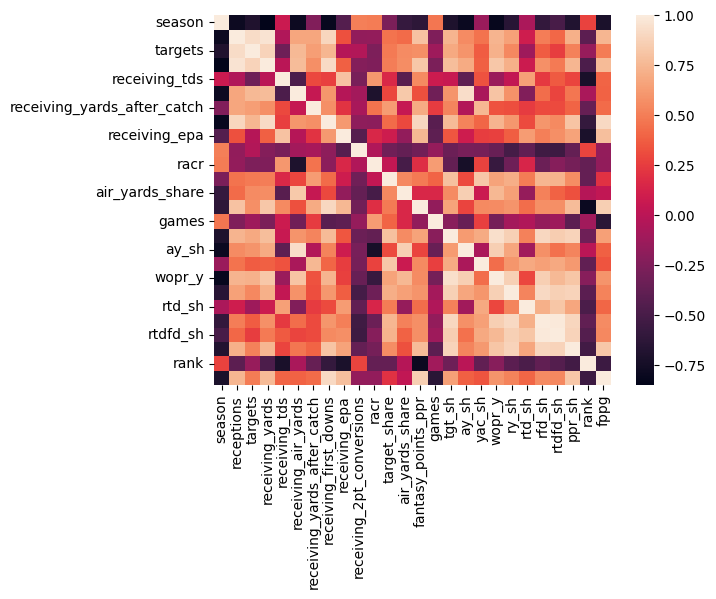

In [23]:
sns.heatmap(filtered_df.corr(numeric_only=True))

filtered_df.corr(numeric_only=True)

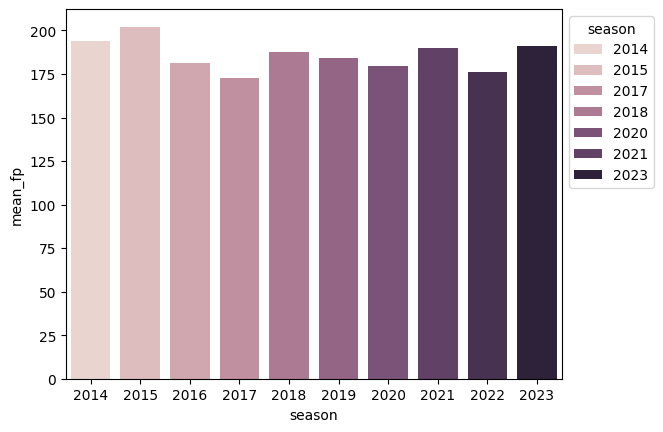

In [27]:
mean_df = top_12_df.groupby('season').agg(mean_fp=('fantasy_points_ppr','mean'))
mean_df.reset_index()

ax = sns.barplot(x='season',
            y='mean_fp',
            hue='season',
            data=mean_df)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

From looking at the bar graph above, the average top 12 TE fantasy points for the season have been fairly consistent over the past ten years. 

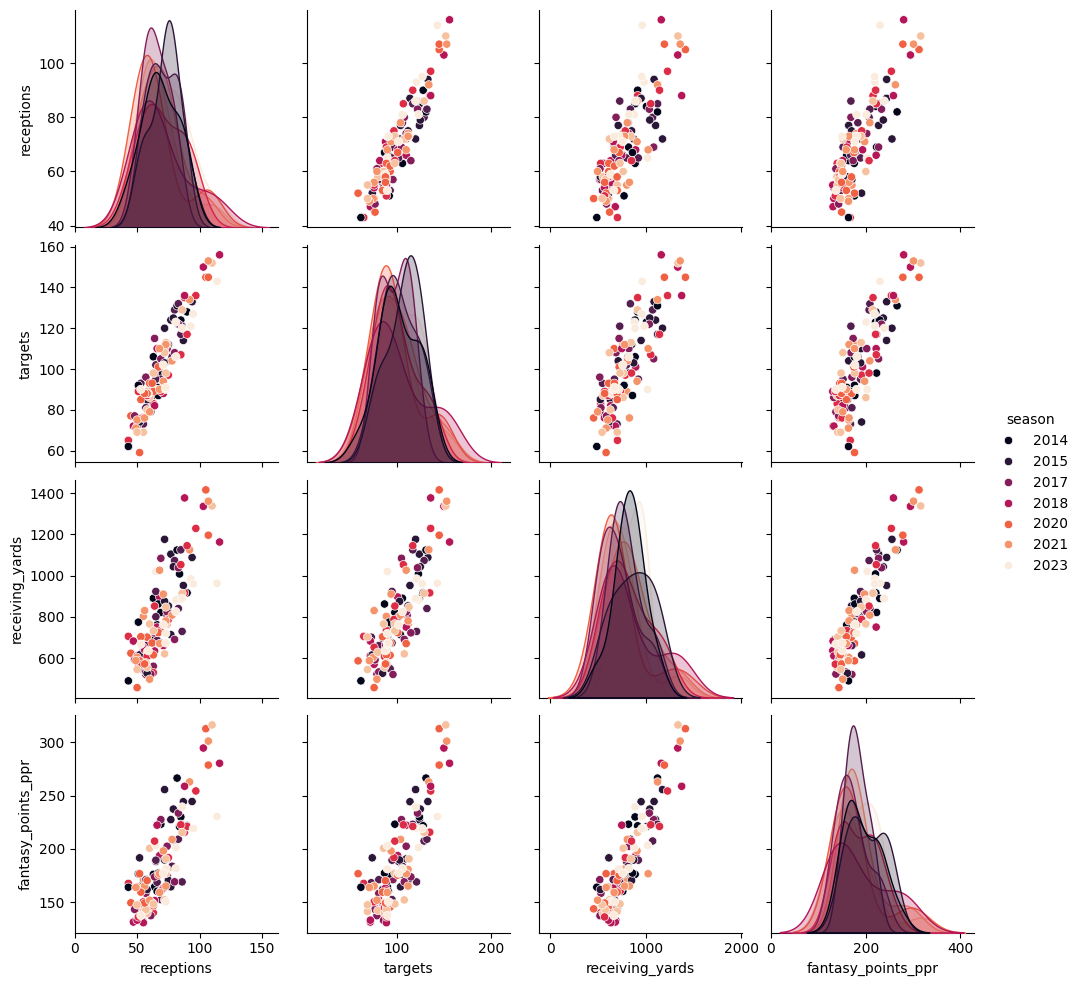

In [42]:
sns.pairplot(top_12_df.iloc[:,[1,2,3,4,14]], hue='season', palette='rocket')
plt.show()

From looking at the data, for two TEs to coexist, they would have to command a 30% target share and a 50% recieving td share for the team. 

In [264]:
likely_2023_data = df.groupby('season').get_group(2023)[df.name.str.contains('Likely')]
likely_2023_data['fantasy_points_ppr']

/tmp/ipykernel_3675/3715611061.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  likely_2023_data = df.groupby('season').get_group(2023)[df.name.str.contains('Likely')]


5947    101.1
Name: fantasy_points_ppr, dtype: float64

In [262]:
#On average for the last 10 years, TE #12 scores 143.73 points
num_12_df = df[df['rank'] == 12]
num_12_df.fantasy_points_ppr.describe()

count     10.00000
mean     143.73000
std        9.23015
min      130.60000
25%      137.22500
50%      141.55000
75%      151.02500
max      160.10000
Name: fantasy_points_ppr, dtype: float64

In [275]:
top_12_df.groupby('season').get_group(2023)[top_12_df['rank'] == 12]['fantasy_points_ppr'].values[0]

/tmp/ipykernel_3675/254360064.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_12_df.groupby('season').get_group(2023)[top_12_df['rank'] == 12]['fantasy_points_ppr'].values[0]


np.float64(137.3)

In [278]:
print(143.73-101)
print(137.3-101)


42.72999999999999
36.30000000000001


I. Likely would have to score between 36.3 to 42.73 more points this upcoming season to become a top 12 TE. Currently he is ranked TE26 in fantasy drafts.\
#Final thoughts\
The likelihood of Likely being a top 12 TE for the season is low without injury to Mark Andrews (the TE ahead of him - ranked TE4). The Ravens would have to feature him more in the redzone which is unlikely with them just trading for D. Henry. 